In [12]:
import numpy as np
import pandas as pd
import matplotlib as plt
import re
import lightgbm as lgb
import datetime as dt
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

In [13]:
borrar = ["Opportunity_Name", "ID", "Brand", "Product_Type", "ASP_converted_Currency", 
          "Prod_Category_A", "Product_Category_B", "Actual_Delivery_Date", "Last_Activity", 
          "ASP_converted_Currency", "Prod_Category_A", "Product_Name", "Delivery_Year", 
          "TRF", "Product_Family", "Account_Name"]

useless = ["Submitted_for_Approval", "Account_Type", "Delivery_Terms", "Size", "Price", "ASP_Currency", 
           "Total_Amount_Currency", "Total_Taxable_Amount_Currency","Quote_Type", "Opportunity_Type"]

dates = ["Account_Created_Date", "Opportunity_Created_Date", "Quote_Expiry_Date", "Last_Modified_Date", 
         "Planned_Delivery_Start_Date", "Planned_Delivery_End_Date"]

target = ["Opportunity_ID", "Stage", "Sales_Contract_No"]

In [14]:
def preprocess(data):
    
    # elimino caracteres prohibidos en los headers
    
    data = data.rename(columns = lambda x:re.sub("[^A-Za-z0-9_]+", "", x))
        
    for d in dates:
        data[d] = pd.to_datetime(data[d])

    # agrego features
    
    data["Contacts"] = data.groupby("Opportunity_ID", sort = False)["Opportunity_ID"].transform("count")
    data["Delivery_Difference"] = (data["Planned_Delivery_End_Date"] - data["Planned_Delivery_Start_Date"]).dt.days
    data["Same_Owner"] = (data.Opportunity_Owner == data.Account_Owner) & (data.Opportunity_Owner == data.Last_Modified_By)
    data["Has_Brand"] = data.Brand != "None"
    data["Has_Contract"] = data.Sales_Contract_No != "None"
    data["Different_Country"] = (data.Billing_Country != data.Territory) & (data.Territory != "None")    
    data.loc[data.TRF == 0, "TRF_Cat"] = 0
    data.loc[(1 <= data.TRF) & (data.TRF <= 7), "TRF_Cat"] = 1
    data.loc[data.TRF > 7, "TRF_Cat"] = 2
    data["Sales"] = data.groupby("Account_Name", sort=False)["Opportunity_ID"].transform(lambda x: x.nunique())
    
    data["Concrete_Offer"] = (data["Planned_Delivery_End_Date"] - data["Opportunity_Created_Date"]).dt.days < 60
    data["Offer_Duration"] = (data["Quote_Expiry_Date"] - data["Opportunity_Created_Date"]).dt.days
    
    data["Total_Volume"] = data.groupby("Opportunity_ID", sort = False)["Total_Amount"].transform("sum")
    data["ASP_max"] = data.groupby("Opportunity_ID", sort = False)["ASP"].transform("max")
    data["ASP_converted_max"] = data.groupby("Opportunity_ID", sort = False)["ASP_converted"].transform("max")
    data.drop(["ASP", "ASP_converted"], axis = 1, inplace = True)

    
    # fabri
    
    data["Territory_Defined"] = data.Territory != "None"
    data["Past_Quote"] = (data["Last_Modified_Date"] - data["Quote_Expiry_Date"]).dt.days
    data["Month"] = data.Month.str[-2:].astype(int)
    
    # casteo a categoricas varias columnas
    categorical = [x for x in data.columns if data[x].dtype == "object"]
    for c in categorical:       
        data[c] = data[c].astype('category')
    
    for c in dates:
        data[c] = pd.to_datetime(data[c])
    
    data["Contact_Duration"] = (data[dates].max(axis = 1) - data[dates].min(axis = 1)).dt.days
    
    # limpio columnas
    
    data = data.drop(borrar + useless + dates + ["Delivery_Quarter"], axis = 1)
    
    #data.drop(data[(data.Contacts > 1) & (data.ASP.isna())].index, inplace = True)
    #data = data.drop_duplicates([x for x in data.columns if x != 'ID'])
    
    return (data)

In [15]:
import catboost as ctb

In [16]:
data = pd.read_csv("Entrenamieto_ECI_2020.csv")

In [17]:
prep = preprocess(data)

In [18]:
prep = prep[(prep.Stage == "Closed Won") | (prep.Stage == "Closed Lost")]
prep.Stage = prep.Stage.replace({"Closed Won": 1, "Closed Lost": 0})

In [19]:
prep.Stage.value_counts()

1    9533
0    7350
Name: Stage, dtype: int64

In [20]:
x_train, x_test, y_train, y_test = train_test_split(prep, prep.Stage, test_size=0.3, random_state=0)

In [21]:
cat_vars = [x for x in x_train.drop(target, axis=1).select_dtypes('category').columns if x != 'Stage']

In [22]:
cat_indexes = [x_train.drop(target, axis=1).columns.get_loc(x) for x in cat_vars]

In [23]:
model = ctb.CatBoostClassifier(num_boost_round=5000,
                               learning_rate=0.015,
                               l2_leaf_reg=3.5,
                               depth=8, 
                               max_bin=400,
                               num_leaves=31,
                               rsm=0.98,
                               eval_metric='Logloss',
                               use_best_model=True,
                               random_seed=42)

In [24]:
model.fit(x_train.drop(target, axis=1), y_train, eval_set=(x_test.drop(target, axis=1), y_test), cat_features=cat_indexes, early_stopping_rounds=800)

0:	learn: 0.6662823	test: 0.6666511	best: 0.6666511 (0)	total: 405ms	remaining: 33m 43s
1:	learn: 0.6433077	test: 0.6438340	best: 0.6438340 (1)	total: 472ms	remaining: 19m 38s
2:	learn: 0.6227070	test: 0.6235025	best: 0.6235025 (2)	total: 495ms	remaining: 13m 44s
3:	learn: 0.6009019	test: 0.6019899	best: 0.6019899 (3)	total: 588ms	remaining: 12m 13s
4:	learn: 0.5819357	test: 0.5833454	best: 0.5833454 (4)	total: 714ms	remaining: 11m 53s
5:	learn: 0.5617875	test: 0.5633887	best: 0.5633887 (5)	total: 808ms	remaining: 11m 12s
6:	learn: 0.5449137	test: 0.5467159	best: 0.5467159 (6)	total: 825ms	remaining: 9m 48s
7:	learn: 0.5287723	test: 0.5307737	best: 0.5307737 (7)	total: 840ms	remaining: 8m 43s
8:	learn: 0.5118491	test: 0.5141362	best: 0.5141362 (8)	total: 935ms	remaining: 8m 38s
9:	learn: 0.4960371	test: 0.4985329	best: 0.4985329 (9)	total: 1.03s	remaining: 8m 35s
10:	learn: 0.4789384	test: 0.4816613	best: 0.4816613 (10)	total: 1.12s	remaining: 8m 27s
11:	learn: 0.4647086	test: 0.467602

93:	learn: 0.1250935	test: 0.1362382	best: 0.1362382 (93)	total: 8.65s	remaining: 7m 31s
94:	learn: 0.1242742	test: 0.1355269	best: 0.1355269 (94)	total: 8.73s	remaining: 7m 30s
95:	learn: 0.1233527	test: 0.1348296	best: 0.1348296 (95)	total: 8.81s	remaining: 7m 30s
96:	learn: 0.1226103	test: 0.1341830	best: 0.1341830 (96)	total: 8.92s	remaining: 7m 31s
97:	learn: 0.1220559	test: 0.1336251	best: 0.1336251 (97)	total: 9s	remaining: 7m 30s
98:	learn: 0.1212737	test: 0.1329227	best: 0.1329227 (98)	total: 9.09s	remaining: 7m 30s
99:	learn: 0.1204717	test: 0.1321400	best: 0.1321400 (99)	total: 9.2s	remaining: 7m 30s
100:	learn: 0.1197235	test: 0.1314000	best: 0.1314000 (100)	total: 9.29s	remaining: 7m 30s
101:	learn: 0.1191597	test: 0.1308703	best: 0.1308703 (101)	total: 9.38s	remaining: 7m 30s
102:	learn: 0.1184484	test: 0.1302551	best: 0.1302551 (102)	total: 9.5s	remaining: 7m 31s
103:	learn: 0.1179405	test: 0.1297717	best: 0.1297717 (103)	total: 9.57s	remaining: 7m 30s
104:	learn: 0.1172

184:	learn: 0.0926769	test: 0.1081679	best: 0.1081679 (184)	total: 18s	remaining: 7m 48s
185:	learn: 0.0924389	test: 0.1079900	best: 0.1079900 (185)	total: 18.1s	remaining: 7m 48s
186:	learn: 0.0922367	test: 0.1077995	best: 0.1077995 (186)	total: 18.2s	remaining: 7m 48s
187:	learn: 0.0920586	test: 0.1076892	best: 0.1076892 (187)	total: 18.3s	remaining: 7m 48s
188:	learn: 0.0918224	test: 0.1074604	best: 0.1074604 (188)	total: 18.4s	remaining: 7m 47s
189:	learn: 0.0916912	test: 0.1073495	best: 0.1073495 (189)	total: 18.5s	remaining: 7m 47s
190:	learn: 0.0915497	test: 0.1072542	best: 0.1072542 (190)	total: 18.6s	remaining: 7m 48s
191:	learn: 0.0912960	test: 0.1070659	best: 0.1070659 (191)	total: 18.8s	remaining: 7m 49s
192:	learn: 0.0910846	test: 0.1068681	best: 0.1068681 (192)	total: 18.9s	remaining: 7m 50s
193:	learn: 0.0908297	test: 0.1066503	best: 0.1066503 (193)	total: 19s	remaining: 7m 51s
194:	learn: 0.0906991	test: 0.1065087	best: 0.1065087 (194)	total: 19.1s	remaining: 7m 51s
195

276:	learn: 0.0777451	test: 0.0966471	best: 0.0966471 (276)	total: 27.9s	remaining: 7m 56s
277:	learn: 0.0776559	test: 0.0966067	best: 0.0966067 (277)	total: 28.1s	remaining: 7m 56s
278:	learn: 0.0775549	test: 0.0965101	best: 0.0965101 (278)	total: 28.2s	remaining: 7m 57s
279:	learn: 0.0774327	test: 0.0963940	best: 0.0963940 (279)	total: 28.4s	remaining: 7m 58s
280:	learn: 0.0773220	test: 0.0963005	best: 0.0963005 (280)	total: 28.5s	remaining: 7m 59s
281:	learn: 0.0772190	test: 0.0962292	best: 0.0962292 (281)	total: 28.6s	remaining: 7m 59s
282:	learn: 0.0771064	test: 0.0961691	best: 0.0961691 (282)	total: 28.8s	remaining: 8m
283:	learn: 0.0770524	test: 0.0961268	best: 0.0961268 (283)	total: 28.9s	remaining: 8m
284:	learn: 0.0769440	test: 0.0960683	best: 0.0960683 (284)	total: 29.1s	remaining: 8m 1s
285:	learn: 0.0767779	test: 0.0959474	best: 0.0959474 (285)	total: 29.3s	remaining: 8m 2s
286:	learn: 0.0767124	test: 0.0958967	best: 0.0958967 (286)	total: 29.4s	remaining: 8m 3s
287:	learn

368:	learn: 0.0696375	test: 0.0907605	best: 0.0907605 (368)	total: 36.9s	remaining: 7m 43s
369:	learn: 0.0695994	test: 0.0907294	best: 0.0907294 (369)	total: 37s	remaining: 7m 43s
370:	learn: 0.0694881	test: 0.0906721	best: 0.0906721 (370)	total: 37.1s	remaining: 7m 43s
371:	learn: 0.0693950	test: 0.0905754	best: 0.0905754 (371)	total: 37.2s	remaining: 7m 43s
372:	learn: 0.0693476	test: 0.0905304	best: 0.0905304 (372)	total: 37.3s	remaining: 7m 43s
373:	learn: 0.0692086	test: 0.0904657	best: 0.0904657 (373)	total: 37.4s	remaining: 7m 42s
374:	learn: 0.0692003	test: 0.0904548	best: 0.0904548 (374)	total: 37.4s	remaining: 7m 41s
375:	learn: 0.0691089	test: 0.0903629	best: 0.0903629 (375)	total: 37.5s	remaining: 7m 41s
376:	learn: 0.0689381	test: 0.0902409	best: 0.0902409 (376)	total: 37.6s	remaining: 7m 41s
377:	learn: 0.0688623	test: 0.0902147	best: 0.0902147 (377)	total: 37.8s	remaining: 7m 41s
378:	learn: 0.0688247	test: 0.0902161	best: 0.0902147 (377)	total: 37.9s	remaining: 7m 41s
3

459:	learn: 0.0640450	test: 0.0873711	best: 0.0873711 (459)	total: 46.9s	remaining: 7m 42s
460:	learn: 0.0639590	test: 0.0873224	best: 0.0873224 (460)	total: 47s	remaining: 7m 43s
461:	learn: 0.0638420	test: 0.0872290	best: 0.0872290 (461)	total: 47.2s	remaining: 7m 43s
462:	learn: 0.0638125	test: 0.0872098	best: 0.0872098 (462)	total: 47.3s	remaining: 7m 43s
463:	learn: 0.0637606	test: 0.0871906	best: 0.0871906 (463)	total: 47.4s	remaining: 7m 43s
464:	learn: 0.0637410	test: 0.0871806	best: 0.0871806 (464)	total: 47.5s	remaining: 7m 43s
465:	learn: 0.0636749	test: 0.0871450	best: 0.0871450 (465)	total: 47.6s	remaining: 7m 43s
466:	learn: 0.0636277	test: 0.0871230	best: 0.0871230 (466)	total: 47.7s	remaining: 7m 43s
467:	learn: 0.0635149	test: 0.0870162	best: 0.0870162 (467)	total: 47.8s	remaining: 7m 42s
468:	learn: 0.0634325	test: 0.0870107	best: 0.0870107 (468)	total: 47.9s	remaining: 7m 43s
469:	learn: 0.0633645	test: 0.0869603	best: 0.0869603 (469)	total: 48.1s	remaining: 7m 43s
4

552:	learn: 0.0591422	test: 0.0844567	best: 0.0844567 (552)	total: 57.1s	remaining: 7m 39s
553:	learn: 0.0590645	test: 0.0844393	best: 0.0844393 (553)	total: 57.2s	remaining: 7m 39s
554:	learn: 0.0590444	test: 0.0844324	best: 0.0844324 (554)	total: 57.4s	remaining: 7m 39s
555:	learn: 0.0590275	test: 0.0844330	best: 0.0844324 (554)	total: 57.5s	remaining: 7m 39s
556:	learn: 0.0589988	test: 0.0844184	best: 0.0844184 (556)	total: 57.6s	remaining: 7m 39s
557:	learn: 0.0589376	test: 0.0843827	best: 0.0843827 (557)	total: 57.7s	remaining: 7m 39s
558:	learn: 0.0588473	test: 0.0843068	best: 0.0843068 (558)	total: 57.8s	remaining: 7m 39s
559:	learn: 0.0588125	test: 0.0842947	best: 0.0842947 (559)	total: 57.9s	remaining: 7m 39s
560:	learn: 0.0587884	test: 0.0842809	best: 0.0842809 (560)	total: 58s	remaining: 7m 38s
561:	learn: 0.0586767	test: 0.0841792	best: 0.0841792 (561)	total: 58.1s	remaining: 7m 38s
562:	learn: 0.0586339	test: 0.0841566	best: 0.0841566 (562)	total: 58.2s	remaining: 7m 38s
5

643:	learn: 0.0548508	test: 0.0818828	best: 0.0818828 (643)	total: 1m 5s	remaining: 7m 24s
644:	learn: 0.0548369	test: 0.0818792	best: 0.0818792 (644)	total: 1m 5s	remaining: 7m 24s
645:	learn: 0.0548011	test: 0.0818652	best: 0.0818652 (645)	total: 1m 5s	remaining: 7m 24s
646:	learn: 0.0547767	test: 0.0818483	best: 0.0818483 (646)	total: 1m 6s	remaining: 7m 24s
647:	learn: 0.0547509	test: 0.0818533	best: 0.0818483 (646)	total: 1m 6s	remaining: 7m 24s
648:	learn: 0.0546948	test: 0.0818595	best: 0.0818483 (646)	total: 1m 6s	remaining: 7m 23s
649:	learn: 0.0546324	test: 0.0817974	best: 0.0817974 (649)	total: 1m 6s	remaining: 7m 23s
650:	learn: 0.0545819	test: 0.0817798	best: 0.0817798 (650)	total: 1m 6s	remaining: 7m 23s
651:	learn: 0.0545189	test: 0.0817208	best: 0.0817208 (651)	total: 1m 6s	remaining: 7m 23s
652:	learn: 0.0544167	test: 0.0816794	best: 0.0816794 (652)	total: 1m 6s	remaining: 7m 23s
653:	learn: 0.0544001	test: 0.0816671	best: 0.0816671 (653)	total: 1m 6s	remaining: 7m 23s

733:	learn: 0.0508207	test: 0.0795811	best: 0.0795811 (733)	total: 1m 14s	remaining: 7m 11s
734:	learn: 0.0507274	test: 0.0795155	best: 0.0795155 (734)	total: 1m 14s	remaining: 7m 11s
735:	learn: 0.0506599	test: 0.0794507	best: 0.0794507 (735)	total: 1m 14s	remaining: 7m 11s
736:	learn: 0.0506457	test: 0.0794434	best: 0.0794434 (736)	total: 1m 14s	remaining: 7m 11s
737:	learn: 0.0506252	test: 0.0794332	best: 0.0794332 (737)	total: 1m 14s	remaining: 7m 11s
738:	learn: 0.0505320	test: 0.0793433	best: 0.0793433 (738)	total: 1m 14s	remaining: 7m 11s
739:	learn: 0.0504748	test: 0.0793067	best: 0.0793067 (739)	total: 1m 14s	remaining: 7m 11s
740:	learn: 0.0504678	test: 0.0792962	best: 0.0792962 (740)	total: 1m 15s	remaining: 7m 11s
741:	learn: 0.0504079	test: 0.0792671	best: 0.0792671 (741)	total: 1m 15s	remaining: 7m 11s
742:	learn: 0.0503390	test: 0.0792392	best: 0.0792392 (742)	total: 1m 15s	remaining: 7m 10s
743:	learn: 0.0502605	test: 0.0792009	best: 0.0792009 (743)	total: 1m 15s	remain

824:	learn: 0.0468440	test: 0.0770675	best: 0.0770657 (823)	total: 1m 22s	remaining: 6m 57s
825:	learn: 0.0468066	test: 0.0770435	best: 0.0770435 (825)	total: 1m 22s	remaining: 6m 57s
826:	learn: 0.0467338	test: 0.0770026	best: 0.0770026 (826)	total: 1m 22s	remaining: 6m 57s
827:	learn: 0.0467281	test: 0.0770014	best: 0.0770014 (827)	total: 1m 22s	remaining: 6m 56s
828:	learn: 0.0467039	test: 0.0769960	best: 0.0769960 (828)	total: 1m 22s	remaining: 6m 56s
829:	learn: 0.0466843	test: 0.0769835	best: 0.0769835 (829)	total: 1m 22s	remaining: 6m 56s
830:	learn: 0.0466787	test: 0.0769832	best: 0.0769832 (830)	total: 1m 23s	remaining: 6m 56s
831:	learn: 0.0466188	test: 0.0769624	best: 0.0769624 (831)	total: 1m 23s	remaining: 6m 56s
832:	learn: 0.0465701	test: 0.0769468	best: 0.0769468 (832)	total: 1m 23s	remaining: 6m 56s
833:	learn: 0.0465596	test: 0.0769435	best: 0.0769435 (833)	total: 1m 23s	remaining: 6m 56s
834:	learn: 0.0465416	test: 0.0769325	best: 0.0769325 (834)	total: 1m 23s	remain

914:	learn: 0.0439812	test: 0.0753745	best: 0.0753745 (914)	total: 1m 30s	remaining: 6m 42s
915:	learn: 0.0439618	test: 0.0753637	best: 0.0753637 (915)	total: 1m 30s	remaining: 6m 42s
916:	learn: 0.0439432	test: 0.0753630	best: 0.0753630 (916)	total: 1m 30s	remaining: 6m 42s
917:	learn: 0.0439325	test: 0.0753538	best: 0.0753538 (917)	total: 1m 30s	remaining: 6m 42s
918:	learn: 0.0438594	test: 0.0752742	best: 0.0752742 (918)	total: 1m 30s	remaining: 6m 41s
919:	learn: 0.0438545	test: 0.0752719	best: 0.0752719 (919)	total: 1m 30s	remaining: 6m 41s
920:	learn: 0.0438139	test: 0.0752217	best: 0.0752217 (920)	total: 1m 30s	remaining: 6m 41s
921:	learn: 0.0437811	test: 0.0751955	best: 0.0751955 (921)	total: 1m 30s	remaining: 6m 41s
922:	learn: 0.0437524	test: 0.0751930	best: 0.0751930 (922)	total: 1m 30s	remaining: 6m 41s
923:	learn: 0.0437266	test: 0.0751797	best: 0.0751797 (923)	total: 1m 30s	remaining: 6m 41s
924:	learn: 0.0437126	test: 0.0751738	best: 0.0751738 (924)	total: 1m 31s	remain

1005:	learn: 0.0408248	test: 0.0732827	best: 0.0732827 (1005)	total: 1m 38s	remaining: 6m 29s
1006:	learn: 0.0408213	test: 0.0732827	best: 0.0732827 (1005)	total: 1m 38s	remaining: 6m 29s
1007:	learn: 0.0407407	test: 0.0732007	best: 0.0732007 (1007)	total: 1m 38s	remaining: 6m 29s
1008:	learn: 0.0407029	test: 0.0731798	best: 0.0731798 (1008)	total: 1m 38s	remaining: 6m 29s
1009:	learn: 0.0406783	test: 0.0731777	best: 0.0731777 (1009)	total: 1m 38s	remaining: 6m 28s
1010:	learn: 0.0406723	test: 0.0731718	best: 0.0731718 (1010)	total: 1m 38s	remaining: 6m 28s
1011:	learn: 0.0406624	test: 0.0731642	best: 0.0731642 (1011)	total: 1m 38s	remaining: 6m 28s
1012:	learn: 0.0406565	test: 0.0731632	best: 0.0731632 (1012)	total: 1m 38s	remaining: 6m 28s
1013:	learn: 0.0406268	test: 0.0731608	best: 0.0731608 (1013)	total: 1m 38s	remaining: 6m 28s
1014:	learn: 0.0406219	test: 0.0731605	best: 0.0731605 (1014)	total: 1m 38s	remaining: 6m 28s
1015:	learn: 0.0405898	test: 0.0731542	best: 0.0731542 (1015

1094:	learn: 0.0379723	test: 0.0717609	best: 0.0717609 (1094)	total: 1m 45s	remaining: 6m 16s
1095:	learn: 0.0379509	test: 0.0717537	best: 0.0717537 (1095)	total: 1m 45s	remaining: 6m 16s
1096:	learn: 0.0379438	test: 0.0717546	best: 0.0717537 (1095)	total: 1m 45s	remaining: 6m 16s
1097:	learn: 0.0379316	test: 0.0717515	best: 0.0717515 (1097)	total: 1m 45s	remaining: 6m 16s
1098:	learn: 0.0378464	test: 0.0716881	best: 0.0716881 (1098)	total: 1m 45s	remaining: 6m 15s
1099:	learn: 0.0377738	test: 0.0716443	best: 0.0716443 (1099)	total: 1m 45s	remaining: 6m 15s
1100:	learn: 0.0377538	test: 0.0716352	best: 0.0716352 (1100)	total: 1m 46s	remaining: 6m 15s
1101:	learn: 0.0377197	test: 0.0716406	best: 0.0716352 (1100)	total: 1m 46s	remaining: 6m 15s
1102:	learn: 0.0376686	test: 0.0716315	best: 0.0716315 (1102)	total: 1m 46s	remaining: 6m 15s
1103:	learn: 0.0376491	test: 0.0716211	best: 0.0716211 (1103)	total: 1m 46s	remaining: 6m 15s
1104:	learn: 0.0375983	test: 0.0715661	best: 0.0715661 (1104

1184:	learn: 0.0353970	test: 0.0701701	best: 0.0701701 (1184)	total: 1m 53s	remaining: 6m 4s
1185:	learn: 0.0353687	test: 0.0701687	best: 0.0701687 (1185)	total: 1m 53s	remaining: 6m 4s
1186:	learn: 0.0353591	test: 0.0701569	best: 0.0701569 (1186)	total: 1m 53s	remaining: 6m 4s
1187:	learn: 0.0353090	test: 0.0700828	best: 0.0700828 (1187)	total: 1m 53s	remaining: 6m 3s
1188:	learn: 0.0352968	test: 0.0700830	best: 0.0700828 (1187)	total: 1m 53s	remaining: 6m 3s
1189:	learn: 0.0352552	test: 0.0700599	best: 0.0700599 (1189)	total: 1m 53s	remaining: 6m 3s
1190:	learn: 0.0352340	test: 0.0700507	best: 0.0700507 (1190)	total: 1m 53s	remaining: 6m 3s
1191:	learn: 0.0351946	test: 0.0700327	best: 0.0700327 (1191)	total: 1m 53s	remaining: 6m 3s
1192:	learn: 0.0351650	test: 0.0700315	best: 0.0700315 (1192)	total: 1m 53s	remaining: 6m 3s
1193:	learn: 0.0351517	test: 0.0700235	best: 0.0700235 (1193)	total: 1m 53s	remaining: 6m 3s
1194:	learn: 0.0351204	test: 0.0700157	best: 0.0700157 (1194)	total: 1

1274:	learn: 0.0328694	test: 0.0687983	best: 0.0687891 (1271)	total: 2m	remaining: 5m 53s
1275:	learn: 0.0328380	test: 0.0687893	best: 0.0687891 (1271)	total: 2m	remaining: 5m 53s
1276:	learn: 0.0328242	test: 0.0687791	best: 0.0687791 (1276)	total: 2m 1s	remaining: 5m 52s
1277:	learn: 0.0328147	test: 0.0687776	best: 0.0687776 (1277)	total: 2m 1s	remaining: 5m 52s
1278:	learn: 0.0327358	test: 0.0687551	best: 0.0687551 (1278)	total: 2m 1s	remaining: 5m 52s
1279:	learn: 0.0327016	test: 0.0687012	best: 0.0687012 (1279)	total: 2m 1s	remaining: 5m 52s
1280:	learn: 0.0326644	test: 0.0686748	best: 0.0686748 (1280)	total: 2m 1s	remaining: 5m 52s
1281:	learn: 0.0326145	test: 0.0686624	best: 0.0686624 (1281)	total: 2m 1s	remaining: 5m 52s
1282:	learn: 0.0325825	test: 0.0686444	best: 0.0686444 (1282)	total: 2m 1s	remaining: 5m 52s
1283:	learn: 0.0325200	test: 0.0685926	best: 0.0685926 (1283)	total: 2m 1s	remaining: 5m 52s
1284:	learn: 0.0325071	test: 0.0685864	best: 0.0685864 (1284)	total: 2m 1s	r

1364:	learn: 0.0307288	test: 0.0675945	best: 0.0675945 (1364)	total: 2m 10s	remaining: 5m 47s
1365:	learn: 0.0306965	test: 0.0675891	best: 0.0675891 (1365)	total: 2m 10s	remaining: 5m 46s
1366:	learn: 0.0306365	test: 0.0675280	best: 0.0675280 (1366)	total: 2m 10s	remaining: 5m 46s
1367:	learn: 0.0306329	test: 0.0675271	best: 0.0675271 (1367)	total: 2m 10s	remaining: 5m 46s
1368:	learn: 0.0306083	test: 0.0675176	best: 0.0675176 (1368)	total: 2m 10s	remaining: 5m 46s
1369:	learn: 0.0305874	test: 0.0674819	best: 0.0674819 (1369)	total: 2m 10s	remaining: 5m 46s
1370:	learn: 0.0305559	test: 0.0674670	best: 0.0674670 (1370)	total: 2m 10s	remaining: 5m 46s
1371:	learn: 0.0305505	test: 0.0674674	best: 0.0674670 (1370)	total: 2m 10s	remaining: 5m 46s
1372:	learn: 0.0305424	test: 0.0674674	best: 0.0674670 (1370)	total: 2m 11s	remaining: 5m 46s
1373:	learn: 0.0305222	test: 0.0674328	best: 0.0674328 (1373)	total: 2m 11s	remaining: 5m 46s
1374:	learn: 0.0305104	test: 0.0674281	best: 0.0674281 (1374

1454:	learn: 0.0290788	test: 0.0666765	best: 0.0666704 (1453)	total: 2m 18s	remaining: 5m 38s
1455:	learn: 0.0290779	test: 0.0666749	best: 0.0666704 (1453)	total: 2m 18s	remaining: 5m 38s
1456:	learn: 0.0290688	test: 0.0666720	best: 0.0666704 (1453)	total: 2m 19s	remaining: 5m 38s
1457:	learn: 0.0290394	test: 0.0666465	best: 0.0666465 (1457)	total: 2m 19s	remaining: 5m 38s
1458:	learn: 0.0290335	test: 0.0666382	best: 0.0666382 (1458)	total: 2m 19s	remaining: 5m 38s
1459:	learn: 0.0290308	test: 0.0666371	best: 0.0666371 (1459)	total: 2m 19s	remaining: 5m 38s
1460:	learn: 0.0290200	test: 0.0666373	best: 0.0666371 (1459)	total: 2m 19s	remaining: 5m 37s
1461:	learn: 0.0290171	test: 0.0666436	best: 0.0666371 (1459)	total: 2m 19s	remaining: 5m 37s
1462:	learn: 0.0289986	test: 0.0666118	best: 0.0666118 (1462)	total: 2m 19s	remaining: 5m 37s
1463:	learn: 0.0289878	test: 0.0666126	best: 0.0666118 (1462)	total: 2m 19s	remaining: 5m 37s
1464:	learn: 0.0289699	test: 0.0665819	best: 0.0665819 (1464

1542:	learn: 0.0274342	test: 0.0657907	best: 0.0657907 (1542)	total: 2m 26s	remaining: 5m 28s
1543:	learn: 0.0274248	test: 0.0657871	best: 0.0657871 (1543)	total: 2m 26s	remaining: 5m 27s
1544:	learn: 0.0274184	test: 0.0657804	best: 0.0657804 (1544)	total: 2m 26s	remaining: 5m 27s
1545:	learn: 0.0274099	test: 0.0657741	best: 0.0657741 (1545)	total: 2m 26s	remaining: 5m 27s
1546:	learn: 0.0274042	test: 0.0657697	best: 0.0657697 (1546)	total: 2m 26s	remaining: 5m 27s
1547:	learn: 0.0274021	test: 0.0657666	best: 0.0657666 (1547)	total: 2m 26s	remaining: 5m 27s
1548:	learn: 0.0273899	test: 0.0657630	best: 0.0657630 (1548)	total: 2m 26s	remaining: 5m 27s
1549:	learn: 0.0273819	test: 0.0657549	best: 0.0657549 (1549)	total: 2m 26s	remaining: 5m 27s
1550:	learn: 0.0273616	test: 0.0657435	best: 0.0657435 (1550)	total: 2m 27s	remaining: 5m 27s
1551:	learn: 0.0273450	test: 0.0657351	best: 0.0657351 (1551)	total: 2m 27s	remaining: 5m 26s
1552:	learn: 0.0273274	test: 0.0657284	best: 0.0657284 (1552

1630:	learn: 0.0259012	test: 0.0649162	best: 0.0649160 (1629)	total: 2m 35s	remaining: 5m 20s
1631:	learn: 0.0258787	test: 0.0649017	best: 0.0649017 (1631)	total: 2m 35s	remaining: 5m 20s
1632:	learn: 0.0258460	test: 0.0648895	best: 0.0648895 (1632)	total: 2m 35s	remaining: 5m 20s
1633:	learn: 0.0258306	test: 0.0648959	best: 0.0648895 (1632)	total: 2m 35s	remaining: 5m 20s
1634:	learn: 0.0258096	test: 0.0648803	best: 0.0648803 (1634)	total: 2m 35s	remaining: 5m 20s
1635:	learn: 0.0257997	test: 0.0648726	best: 0.0648726 (1635)	total: 2m 35s	remaining: 5m 20s
1636:	learn: 0.0257926	test: 0.0648766	best: 0.0648726 (1635)	total: 2m 36s	remaining: 5m 20s
1637:	learn: 0.0257761	test: 0.0648689	best: 0.0648689 (1637)	total: 2m 36s	remaining: 5m 20s
1638:	learn: 0.0257761	test: 0.0648689	best: 0.0648689 (1638)	total: 2m 36s	remaining: 5m 20s
1639:	learn: 0.0257443	test: 0.0648195	best: 0.0648195 (1639)	total: 2m 36s	remaining: 5m 20s
1640:	learn: 0.0257419	test: 0.0648210	best: 0.0648195 (1639

1720:	learn: 0.0245991	test: 0.0643284	best: 0.0643151 (1710)	total: 2m 46s	remaining: 5m 17s
1721:	learn: 0.0245956	test: 0.0643267	best: 0.0643151 (1710)	total: 2m 46s	remaining: 5m 17s
1722:	learn: 0.0245788	test: 0.0643319	best: 0.0643151 (1710)	total: 2m 46s	remaining: 5m 17s
1723:	learn: 0.0245485	test: 0.0643248	best: 0.0643151 (1710)	total: 2m 46s	remaining: 5m 16s
1724:	learn: 0.0245264	test: 0.0643177	best: 0.0643151 (1710)	total: 2m 46s	remaining: 5m 16s
1725:	learn: 0.0244972	test: 0.0642909	best: 0.0642909 (1725)	total: 2m 47s	remaining: 5m 16s
1726:	learn: 0.0244929	test: 0.0642890	best: 0.0642890 (1726)	total: 2m 47s	remaining: 5m 16s
1727:	learn: 0.0244846	test: 0.0642892	best: 0.0642890 (1726)	total: 2m 47s	remaining: 5m 16s
1728:	learn: 0.0244827	test: 0.0642867	best: 0.0642867 (1728)	total: 2m 47s	remaining: 5m 16s
1729:	learn: 0.0244785	test: 0.0642853	best: 0.0642853 (1729)	total: 2m 47s	remaining: 5m 16s
1730:	learn: 0.0244580	test: 0.0642669	best: 0.0642669 (1730

1808:	learn: 0.0233600	test: 0.0638197	best: 0.0638197 (1808)	total: 2m 55s	remaining: 5m 9s
1809:	learn: 0.0233369	test: 0.0638049	best: 0.0638049 (1809)	total: 2m 55s	remaining: 5m 9s
1810:	learn: 0.0233261	test: 0.0638052	best: 0.0638049 (1809)	total: 2m 55s	remaining: 5m 9s
1811:	learn: 0.0233185	test: 0.0637993	best: 0.0637993 (1811)	total: 2m 55s	remaining: 5m 9s
1812:	learn: 0.0233094	test: 0.0637899	best: 0.0637899 (1812)	total: 2m 55s	remaining: 5m 9s
1813:	learn: 0.0232970	test: 0.0637876	best: 0.0637876 (1813)	total: 2m 56s	remaining: 5m 9s
1814:	learn: 0.0232583	test: 0.0637782	best: 0.0637782 (1814)	total: 2m 56s	remaining: 5m 9s
1815:	learn: 0.0232544	test: 0.0637840	best: 0.0637782 (1814)	total: 2m 56s	remaining: 5m 8s
1816:	learn: 0.0232107	test: 0.0637682	best: 0.0637682 (1816)	total: 2m 56s	remaining: 5m 8s
1817:	learn: 0.0231935	test: 0.0637852	best: 0.0637682 (1816)	total: 2m 56s	remaining: 5m 8s
1818:	learn: 0.0231848	test: 0.0637828	best: 0.0637682 (1816)	total: 2

1897:	learn: 0.0221749	test: 0.0635421	best: 0.0635421 (1897)	total: 3m 4s	remaining: 5m 1s
1898:	learn: 0.0221663	test: 0.0635329	best: 0.0635329 (1898)	total: 3m 4s	remaining: 5m 1s
1899:	learn: 0.0221457	test: 0.0635120	best: 0.0635120 (1899)	total: 3m 4s	remaining: 5m 1s
1900:	learn: 0.0221457	test: 0.0635120	best: 0.0635120 (1900)	total: 3m 4s	remaining: 5m
1901:	learn: 0.0221425	test: 0.0635075	best: 0.0635075 (1901)	total: 3m 4s	remaining: 5m
1902:	learn: 0.0221368	test: 0.0634986	best: 0.0634986 (1902)	total: 3m 4s	remaining: 5m
1903:	learn: 0.0221298	test: 0.0634969	best: 0.0634969 (1903)	total: 3m 4s	remaining: 5m
1904:	learn: 0.0221251	test: 0.0634968	best: 0.0634968 (1904)	total: 3m 4s	remaining: 5m
1905:	learn: 0.0221058	test: 0.0634909	best: 0.0634909 (1905)	total: 3m 5s	remaining: 5m
1906:	learn: 0.0221058	test: 0.0634909	best: 0.0634909 (1906)	total: 3m 5s	remaining: 5m
1907:	learn: 0.0220953	test: 0.0634927	best: 0.0634909 (1906)	total: 3m 5s	remaining: 5m
1908:	learn:

1986:	learn: 0.0212197	test: 0.0632177	best: 0.0632121 (1981)	total: 3m 12s	remaining: 4m 52s
1987:	learn: 0.0212009	test: 0.0632154	best: 0.0632121 (1981)	total: 3m 13s	remaining: 4m 52s
1988:	learn: 0.0211941	test: 0.0632054	best: 0.0632054 (1988)	total: 3m 13s	remaining: 4m 52s
1989:	learn: 0.0211923	test: 0.0632043	best: 0.0632043 (1989)	total: 3m 13s	remaining: 4m 52s
1990:	learn: 0.0211715	test: 0.0631937	best: 0.0631937 (1990)	total: 3m 13s	remaining: 4m 52s
1991:	learn: 0.0211664	test: 0.0631898	best: 0.0631898 (1991)	total: 3m 13s	remaining: 4m 52s
1992:	learn: 0.0211642	test: 0.0631894	best: 0.0631894 (1992)	total: 3m 13s	remaining: 4m 51s
1993:	learn: 0.0211609	test: 0.0631896	best: 0.0631894 (1992)	total: 3m 13s	remaining: 4m 51s
1994:	learn: 0.0211484	test: 0.0631772	best: 0.0631772 (1994)	total: 3m 13s	remaining: 4m 51s
1995:	learn: 0.0211434	test: 0.0631798	best: 0.0631772 (1994)	total: 3m 13s	remaining: 4m 51s
1996:	learn: 0.0211399	test: 0.0631840	best: 0.0631772 (1994

2074:	learn: 0.0204268	test: 0.0628302	best: 0.0628258 (2062)	total: 3m 22s	remaining: 4m 44s
2075:	learn: 0.0204151	test: 0.0628186	best: 0.0628186 (2075)	total: 3m 22s	remaining: 4m 44s
2076:	learn: 0.0203953	test: 0.0628072	best: 0.0628072 (2076)	total: 3m 22s	remaining: 4m 44s
2077:	learn: 0.0203786	test: 0.0627992	best: 0.0627992 (2077)	total: 3m 22s	remaining: 4m 44s
2078:	learn: 0.0203587	test: 0.0627868	best: 0.0627868 (2078)	total: 3m 22s	remaining: 4m 44s
2079:	learn: 0.0203480	test: 0.0627880	best: 0.0627868 (2078)	total: 3m 22s	remaining: 4m 44s
2080:	learn: 0.0203431	test: 0.0627934	best: 0.0627868 (2078)	total: 3m 23s	remaining: 4m 44s
2081:	learn: 0.0203411	test: 0.0627939	best: 0.0627868 (2078)	total: 3m 23s	remaining: 4m 44s
2082:	learn: 0.0203393	test: 0.0627926	best: 0.0627868 (2078)	total: 3m 23s	remaining: 4m 44s
2083:	learn: 0.0203364	test: 0.0627913	best: 0.0627868 (2078)	total: 3m 23s	remaining: 4m 44s
2084:	learn: 0.0203328	test: 0.0627974	best: 0.0627868 (2078

2164:	learn: 0.0196154	test: 0.0624017	best: 0.0624017 (2164)	total: 3m 32s	remaining: 4m 38s
2165:	learn: 0.0195875	test: 0.0623928	best: 0.0623928 (2165)	total: 3m 32s	remaining: 4m 37s
2166:	learn: 0.0195624	test: 0.0623740	best: 0.0623740 (2166)	total: 3m 32s	remaining: 4m 37s
2167:	learn: 0.0195509	test: 0.0623646	best: 0.0623646 (2167)	total: 3m 32s	remaining: 4m 37s
2168:	learn: 0.0195459	test: 0.0623653	best: 0.0623646 (2167)	total: 3m 32s	remaining: 4m 37s
2169:	learn: 0.0195388	test: 0.0623565	best: 0.0623565 (2169)	total: 3m 32s	remaining: 4m 37s
2170:	learn: 0.0195239	test: 0.0623613	best: 0.0623565 (2169)	total: 3m 32s	remaining: 4m 37s
2171:	learn: 0.0195195	test: 0.0623678	best: 0.0623565 (2169)	total: 3m 33s	remaining: 4m 37s
2172:	learn: 0.0195020	test: 0.0623610	best: 0.0623565 (2169)	total: 3m 33s	remaining: 4m 37s
2173:	learn: 0.0195000	test: 0.0623617	best: 0.0623565 (2169)	total: 3m 33s	remaining: 4m 37s
2174:	learn: 0.0194958	test: 0.0623717	best: 0.0623565 (2169

2253:	learn: 0.0189246	test: 0.0620616	best: 0.0620505 (2247)	total: 3m 40s	remaining: 4m 29s
2254:	learn: 0.0188974	test: 0.0620364	best: 0.0620364 (2254)	total: 3m 41s	remaining: 4m 29s
2255:	learn: 0.0188761	test: 0.0620141	best: 0.0620141 (2255)	total: 3m 41s	remaining: 4m 29s
2256:	learn: 0.0188636	test: 0.0620290	best: 0.0620141 (2255)	total: 3m 41s	remaining: 4m 28s
2257:	learn: 0.0188526	test: 0.0620152	best: 0.0620141 (2255)	total: 3m 41s	remaining: 4m 28s
2258:	learn: 0.0188396	test: 0.0620149	best: 0.0620141 (2255)	total: 3m 41s	remaining: 4m 28s
2259:	learn: 0.0188395	test: 0.0620149	best: 0.0620141 (2255)	total: 3m 41s	remaining: 4m 28s
2260:	learn: 0.0188342	test: 0.0620157	best: 0.0620141 (2255)	total: 3m 41s	remaining: 4m 28s
2261:	learn: 0.0188276	test: 0.0620109	best: 0.0620109 (2261)	total: 3m 41s	remaining: 4m 28s
2262:	learn: 0.0188259	test: 0.0620154	best: 0.0620109 (2261)	total: 3m 41s	remaining: 4m 28s
2263:	learn: 0.0187971	test: 0.0620344	best: 0.0620109 (2261

2341:	learn: 0.0182529	test: 0.0617847	best: 0.0617831 (2339)	total: 3m 50s	remaining: 4m 21s
2342:	learn: 0.0182519	test: 0.0617845	best: 0.0617831 (2339)	total: 3m 50s	remaining: 4m 21s
2343:	learn: 0.0182519	test: 0.0617845	best: 0.0617831 (2339)	total: 3m 50s	remaining: 4m 21s
2344:	learn: 0.0182447	test: 0.0617765	best: 0.0617765 (2344)	total: 3m 50s	remaining: 4m 21s
2345:	learn: 0.0182328	test: 0.0617712	best: 0.0617712 (2345)	total: 3m 50s	remaining: 4m 21s
2346:	learn: 0.0182304	test: 0.0617707	best: 0.0617707 (2346)	total: 3m 50s	remaining: 4m 20s
2347:	learn: 0.0182269	test: 0.0617729	best: 0.0617707 (2346)	total: 3m 50s	remaining: 4m 20s
2348:	learn: 0.0182241	test: 0.0617740	best: 0.0617707 (2346)	total: 3m 51s	remaining: 4m 20s
2349:	learn: 0.0182210	test: 0.0617736	best: 0.0617707 (2346)	total: 3m 51s	remaining: 4m 20s
2350:	learn: 0.0182210	test: 0.0617736	best: 0.0617707 (2346)	total: 3m 51s	remaining: 4m 20s
2351:	learn: 0.0182186	test: 0.0617708	best: 0.0617707 (2346

2431:	learn: 0.0176236	test: 0.0615565	best: 0.0615493 (2429)	total: 3m 58s	remaining: 4m 12s
2432:	learn: 0.0176205	test: 0.0615551	best: 0.0615493 (2429)	total: 3m 58s	remaining: 4m 12s
2433:	learn: 0.0176049	test: 0.0615432	best: 0.0615432 (2433)	total: 3m 59s	remaining: 4m 12s
2434:	learn: 0.0175944	test: 0.0615453	best: 0.0615432 (2433)	total: 3m 59s	remaining: 4m 11s
2435:	learn: 0.0175820	test: 0.0615413	best: 0.0615413 (2435)	total: 3m 59s	remaining: 4m 11s
2436:	learn: 0.0175795	test: 0.0615414	best: 0.0615413 (2435)	total: 3m 59s	remaining: 4m 11s
2437:	learn: 0.0175653	test: 0.0615427	best: 0.0615413 (2435)	total: 3m 59s	remaining: 4m 11s
2438:	learn: 0.0175593	test: 0.0615363	best: 0.0615363 (2438)	total: 3m 59s	remaining: 4m 11s
2439:	learn: 0.0175584	test: 0.0615359	best: 0.0615359 (2439)	total: 3m 59s	remaining: 4m 11s
2440:	learn: 0.0175461	test: 0.0615346	best: 0.0615346 (2440)	total: 3m 59s	remaining: 4m 11s
2441:	learn: 0.0175461	test: 0.0615346	best: 0.0615346 (2441

2522:	learn: 0.0170010	test: 0.0612638	best: 0.0612594 (2516)	total: 4m 7s	remaining: 4m 2s
2523:	learn: 0.0169827	test: 0.0612562	best: 0.0612562 (2523)	total: 4m 7s	remaining: 4m 2s
2524:	learn: 0.0169811	test: 0.0612613	best: 0.0612562 (2523)	total: 4m 7s	remaining: 4m 2s
2525:	learn: 0.0169811	test: 0.0612612	best: 0.0612562 (2523)	total: 4m 7s	remaining: 4m 2s
2526:	learn: 0.0169760	test: 0.0612702	best: 0.0612562 (2523)	total: 4m 7s	remaining: 4m 2s
2527:	learn: 0.0169649	test: 0.0612757	best: 0.0612562 (2523)	total: 4m 7s	remaining: 4m 2s
2528:	learn: 0.0169581	test: 0.0612696	best: 0.0612562 (2523)	total: 4m 8s	remaining: 4m 2s
2529:	learn: 0.0169514	test: 0.0612636	best: 0.0612562 (2523)	total: 4m 8s	remaining: 4m 2s
2530:	learn: 0.0169389	test: 0.0612532	best: 0.0612532 (2530)	total: 4m 8s	remaining: 4m 2s
2531:	learn: 0.0169389	test: 0.0612532	best: 0.0612532 (2530)	total: 4m 8s	remaining: 4m 2s
2532:	learn: 0.0169373	test: 0.0612583	best: 0.0612532 (2530)	total: 4m 8s	remai

2612:	learn: 0.0163872	test: 0.0611240	best: 0.0611047 (2591)	total: 4m 15s	remaining: 3m 53s
2613:	learn: 0.0163863	test: 0.0611230	best: 0.0611047 (2591)	total: 4m 16s	remaining: 3m 53s
2614:	learn: 0.0163781	test: 0.0611352	best: 0.0611047 (2591)	total: 4m 16s	remaining: 3m 53s
2615:	learn: 0.0163731	test: 0.0611287	best: 0.0611047 (2591)	total: 4m 16s	remaining: 3m 53s
2616:	learn: 0.0163658	test: 0.0611250	best: 0.0611047 (2591)	total: 4m 16s	remaining: 3m 53s
2617:	learn: 0.0163658	test: 0.0611250	best: 0.0611047 (2591)	total: 4m 16s	remaining: 3m 53s
2618:	learn: 0.0163616	test: 0.0611253	best: 0.0611047 (2591)	total: 4m 16s	remaining: 3m 53s
2619:	learn: 0.0163616	test: 0.0611253	best: 0.0611047 (2591)	total: 4m 16s	remaining: 3m 53s
2620:	learn: 0.0163549	test: 0.0611288	best: 0.0611047 (2591)	total: 4m 16s	remaining: 3m 52s
2621:	learn: 0.0163536	test: 0.0611278	best: 0.0611047 (2591)	total: 4m 16s	remaining: 3m 52s
2622:	learn: 0.0163521	test: 0.0611269	best: 0.0611047 (2591

2701:	learn: 0.0158007	test: 0.0609217	best: 0.0609217 (2701)	total: 4m 25s	remaining: 3m 45s
2702:	learn: 0.0158007	test: 0.0609217	best: 0.0609217 (2702)	total: 4m 25s	remaining: 3m 45s
2703:	learn: 0.0158007	test: 0.0609217	best: 0.0609217 (2702)	total: 4m 25s	remaining: 3m 45s
2704:	learn: 0.0157980	test: 0.0609201	best: 0.0609201 (2704)	total: 4m 25s	remaining: 3m 45s
2705:	learn: 0.0157897	test: 0.0609111	best: 0.0609111 (2705)	total: 4m 25s	remaining: 3m 45s
2706:	learn: 0.0157897	test: 0.0609111	best: 0.0609111 (2706)	total: 4m 25s	remaining: 3m 45s
2707:	learn: 0.0157832	test: 0.0609095	best: 0.0609095 (2707)	total: 4m 25s	remaining: 3m 44s
2708:	learn: 0.0157744	test: 0.0609123	best: 0.0609095 (2707)	total: 4m 25s	remaining: 3m 44s
2709:	learn: 0.0157624	test: 0.0609090	best: 0.0609090 (2709)	total: 4m 26s	remaining: 3m 44s
2710:	learn: 0.0157624	test: 0.0609089	best: 0.0609089 (2710)	total: 4m 26s	remaining: 3m 44s
2711:	learn: 0.0157532	test: 0.0609185	best: 0.0609089 (2710

2791:	learn: 0.0153270	test: 0.0608947	best: 0.0608947 (2791)	total: 4m 33s	remaining: 3m 36s
2792:	learn: 0.0153270	test: 0.0608946	best: 0.0608946 (2792)	total: 4m 33s	remaining: 3m 36s
2793:	learn: 0.0153181	test: 0.0608867	best: 0.0608867 (2793)	total: 4m 34s	remaining: 3m 36s
2794:	learn: 0.0153181	test: 0.0608867	best: 0.0608867 (2794)	total: 4m 34s	remaining: 3m 36s
2795:	learn: 0.0153123	test: 0.0608860	best: 0.0608860 (2795)	total: 4m 34s	remaining: 3m 36s
2796:	learn: 0.0153104	test: 0.0608819	best: 0.0608819 (2796)	total: 4m 34s	remaining: 3m 36s
2797:	learn: 0.0152931	test: 0.0608678	best: 0.0608678 (2797)	total: 4m 34s	remaining: 3m 35s
2798:	learn: 0.0152862	test: 0.0608721	best: 0.0608678 (2797)	total: 4m 34s	remaining: 3m 35s
2799:	learn: 0.0152795	test: 0.0608766	best: 0.0608678 (2797)	total: 4m 34s	remaining: 3m 35s
2800:	learn: 0.0152795	test: 0.0608767	best: 0.0608678 (2797)	total: 4m 34s	remaining: 3m 35s
2801:	learn: 0.0152795	test: 0.0608766	best: 0.0608678 (2797

2880:	learn: 0.0148230	test: 0.0607956	best: 0.0607956 (2880)	total: 4m 42s	remaining: 3m 27s
2881:	learn: 0.0148207	test: 0.0608016	best: 0.0607956 (2880)	total: 4m 42s	remaining: 3m 27s
2882:	learn: 0.0148128	test: 0.0608002	best: 0.0607956 (2880)	total: 4m 42s	remaining: 3m 27s
2883:	learn: 0.0148094	test: 0.0608021	best: 0.0607956 (2880)	total: 4m 42s	remaining: 3m 27s
2884:	learn: 0.0147955	test: 0.0607930	best: 0.0607930 (2884)	total: 4m 42s	remaining: 3m 27s
2885:	learn: 0.0147918	test: 0.0607888	best: 0.0607888 (2885)	total: 4m 42s	remaining: 3m 27s
2886:	learn: 0.0147827	test: 0.0607922	best: 0.0607888 (2885)	total: 4m 43s	remaining: 3m 27s
2887:	learn: 0.0147827	test: 0.0607922	best: 0.0607888 (2885)	total: 4m 43s	remaining: 3m 27s
2888:	learn: 0.0147730	test: 0.0607875	best: 0.0607875 (2888)	total: 4m 43s	remaining: 3m 27s
2889:	learn: 0.0147598	test: 0.0607959	best: 0.0607875 (2888)	total: 4m 43s	remaining: 3m 27s
2890:	learn: 0.0147598	test: 0.0607959	best: 0.0607875 (2888

2968:	learn: 0.0143804	test: 0.0606673	best: 0.0606655 (2958)	total: 4m 52s	remaining: 3m 20s
2969:	learn: 0.0143804	test: 0.0606673	best: 0.0606655 (2958)	total: 4m 52s	remaining: 3m 19s
2970:	learn: 0.0143782	test: 0.0606689	best: 0.0606655 (2958)	total: 4m 52s	remaining: 3m 19s
2971:	learn: 0.0143782	test: 0.0606689	best: 0.0606655 (2958)	total: 4m 52s	remaining: 3m 19s
2972:	learn: 0.0143738	test: 0.0606632	best: 0.0606632 (2972)	total: 4m 52s	remaining: 3m 19s
2973:	learn: 0.0143717	test: 0.0606648	best: 0.0606632 (2972)	total: 4m 52s	remaining: 3m 19s
2974:	learn: 0.0143655	test: 0.0606603	best: 0.0606603 (2974)	total: 4m 53s	remaining: 3m 19s
2975:	learn: 0.0143655	test: 0.0606603	best: 0.0606603 (2975)	total: 4m 53s	remaining: 3m 19s
2976:	learn: 0.0143654	test: 0.0606603	best: 0.0606603 (2975)	total: 4m 53s	remaining: 3m 19s
2977:	learn: 0.0143654	test: 0.0606603	best: 0.0606603 (2975)	total: 4m 53s	remaining: 3m 19s
2978:	learn: 0.0143474	test: 0.0606533	best: 0.0606533 (2978

3056:	learn: 0.0140477	test: 0.0606260	best: 0.0605876 (3042)	total: 5m 1s	remaining: 3m 11s
3057:	learn: 0.0140477	test: 0.0606260	best: 0.0605876 (3042)	total: 5m 1s	remaining: 3m 11s
3058:	learn: 0.0140431	test: 0.0606294	best: 0.0605876 (3042)	total: 5m 1s	remaining: 3m 11s
3059:	learn: 0.0140405	test: 0.0606264	best: 0.0605876 (3042)	total: 5m 1s	remaining: 3m 11s
3060:	learn: 0.0140332	test: 0.0606277	best: 0.0605876 (3042)	total: 5m 1s	remaining: 3m 11s
3061:	learn: 0.0140332	test: 0.0606278	best: 0.0605876 (3042)	total: 5m 1s	remaining: 3m 10s
3062:	learn: 0.0140332	test: 0.0606277	best: 0.0605876 (3042)	total: 5m 1s	remaining: 3m 10s
3063:	learn: 0.0140332	test: 0.0606277	best: 0.0605876 (3042)	total: 5m 1s	remaining: 3m 10s
3064:	learn: 0.0140311	test: 0.0606279	best: 0.0605876 (3042)	total: 5m 2s	remaining: 3m 10s
3065:	learn: 0.0140202	test: 0.0606361	best: 0.0605876 (3042)	total: 5m 2s	remaining: 3m 10s
3066:	learn: 0.0140143	test: 0.0606270	best: 0.0605876 (3042)	total: 5

3147:	learn: 0.0137928	test: 0.0605475	best: 0.0605408 (3136)	total: 5m 10s	remaining: 3m 2s
3148:	learn: 0.0137886	test: 0.0605412	best: 0.0605408 (3136)	total: 5m 10s	remaining: 3m 2s
3149:	learn: 0.0137886	test: 0.0605412	best: 0.0605408 (3136)	total: 5m 10s	remaining: 3m 2s
3150:	learn: 0.0137886	test: 0.0605412	best: 0.0605408 (3136)	total: 5m 10s	remaining: 3m 2s
3151:	learn: 0.0137886	test: 0.0605412	best: 0.0605408 (3136)	total: 5m 10s	remaining: 3m 2s
3152:	learn: 0.0137870	test: 0.0605408	best: 0.0605408 (3152)	total: 5m 11s	remaining: 3m 2s
3153:	learn: 0.0137870	test: 0.0605407	best: 0.0605407 (3153)	total: 5m 11s	remaining: 3m 2s
3154:	learn: 0.0137870	test: 0.0605407	best: 0.0605407 (3154)	total: 5m 11s	remaining: 3m 2s
3155:	learn: 0.0137870	test: 0.0605407	best: 0.0605407 (3155)	total: 5m 11s	remaining: 3m 1s
3156:	learn: 0.0137708	test: 0.0605500	best: 0.0605407 (3155)	total: 5m 11s	remaining: 3m 1s
3157:	learn: 0.0137678	test: 0.0605508	best: 0.0605407 (3155)	total: 5

3237:	learn: 0.0134389	test: 0.0605643	best: 0.0605252 (3202)	total: 5m 19s	remaining: 2m 53s
3238:	learn: 0.0134374	test: 0.0605682	best: 0.0605252 (3202)	total: 5m 19s	remaining: 2m 53s
3239:	learn: 0.0134360	test: 0.0605678	best: 0.0605252 (3202)	total: 5m 19s	remaining: 2m 53s
3240:	learn: 0.0134360	test: 0.0605677	best: 0.0605252 (3202)	total: 5m 19s	remaining: 2m 53s
3241:	learn: 0.0134335	test: 0.0605692	best: 0.0605252 (3202)	total: 5m 19s	remaining: 2m 53s
3242:	learn: 0.0134160	test: 0.0605714	best: 0.0605252 (3202)	total: 5m 19s	remaining: 2m 53s
3243:	learn: 0.0134148	test: 0.0605716	best: 0.0605252 (3202)	total: 5m 19s	remaining: 2m 53s
3244:	learn: 0.0134147	test: 0.0605714	best: 0.0605252 (3202)	total: 5m 19s	remaining: 2m 52s
3245:	learn: 0.0134064	test: 0.0605513	best: 0.0605252 (3202)	total: 5m 19s	remaining: 2m 52s
3246:	learn: 0.0134035	test: 0.0605560	best: 0.0605252 (3202)	total: 5m 20s	remaining: 2m 52s
3247:	learn: 0.0133909	test: 0.0605529	best: 0.0605252 (3202

3326:	learn: 0.0131363	test: 0.0605088	best: 0.0604781 (3283)	total: 5m 26s	remaining: 2m 44s
3327:	learn: 0.0131363	test: 0.0605088	best: 0.0604781 (3283)	total: 5m 26s	remaining: 2m 43s
3328:	learn: 0.0131344	test: 0.0605101	best: 0.0604781 (3283)	total: 5m 26s	remaining: 2m 43s
3329:	learn: 0.0131343	test: 0.0605102	best: 0.0604781 (3283)	total: 5m 26s	remaining: 2m 43s
3330:	learn: 0.0131343	test: 0.0605102	best: 0.0604781 (3283)	total: 5m 26s	remaining: 2m 43s
3331:	learn: 0.0131342	test: 0.0605107	best: 0.0604781 (3283)	total: 5m 26s	remaining: 2m 43s
3332:	learn: 0.0131255	test: 0.0605172	best: 0.0604781 (3283)	total: 5m 26s	remaining: 2m 43s
3333:	learn: 0.0131255	test: 0.0605172	best: 0.0604781 (3283)	total: 5m 26s	remaining: 2m 43s
3334:	learn: 0.0131194	test: 0.0605204	best: 0.0604781 (3283)	total: 5m 27s	remaining: 2m 43s
3335:	learn: 0.0131194	test: 0.0605205	best: 0.0604781 (3283)	total: 5m 27s	remaining: 2m 43s
3336:	learn: 0.0131096	test: 0.0605209	best: 0.0604781 (3283

3415:	learn: 0.0128800	test: 0.0604498	best: 0.0604498 (3415)	total: 5m 34s	remaining: 2m 35s
3416:	learn: 0.0128741	test: 0.0604468	best: 0.0604468 (3416)	total: 5m 34s	remaining: 2m 35s
3417:	learn: 0.0128741	test: 0.0604468	best: 0.0604468 (3416)	total: 5m 34s	remaining: 2m 35s
3418:	learn: 0.0128719	test: 0.0604481	best: 0.0604468 (3416)	total: 5m 35s	remaining: 2m 34s
3419:	learn: 0.0128663	test: 0.0604527	best: 0.0604468 (3416)	total: 5m 35s	remaining: 2m 34s
3420:	learn: 0.0128607	test: 0.0604589	best: 0.0604468 (3416)	total: 5m 35s	remaining: 2m 34s
3421:	learn: 0.0128571	test: 0.0604643	best: 0.0604468 (3416)	total: 5m 35s	remaining: 2m 34s
3422:	learn: 0.0128473	test: 0.0604624	best: 0.0604468 (3416)	total: 5m 35s	remaining: 2m 34s
3423:	learn: 0.0128433	test: 0.0604687	best: 0.0604468 (3416)	total: 5m 35s	remaining: 2m 34s
3424:	learn: 0.0128386	test: 0.0604605	best: 0.0604468 (3416)	total: 5m 35s	remaining: 2m 34s
3425:	learn: 0.0128368	test: 0.0604621	best: 0.0604468 (3416

3504:	learn: 0.0126412	test: 0.0604790	best: 0.0604468 (3416)	total: 5m 43s	remaining: 2m 26s
3505:	learn: 0.0126412	test: 0.0604790	best: 0.0604468 (3416)	total: 5m 43s	remaining: 2m 26s
3506:	learn: 0.0126412	test: 0.0604790	best: 0.0604468 (3416)	total: 5m 44s	remaining: 2m 26s
3507:	learn: 0.0126312	test: 0.0604797	best: 0.0604468 (3416)	total: 5m 44s	remaining: 2m 26s
3508:	learn: 0.0126312	test: 0.0604797	best: 0.0604468 (3416)	total: 5m 44s	remaining: 2m 26s
3509:	learn: 0.0126302	test: 0.0604768	best: 0.0604468 (3416)	total: 5m 44s	remaining: 2m 26s
3510:	learn: 0.0126302	test: 0.0604770	best: 0.0604468 (3416)	total: 5m 44s	remaining: 2m 26s
3511:	learn: 0.0126302	test: 0.0604770	best: 0.0604468 (3416)	total: 5m 44s	remaining: 2m 25s
3512:	learn: 0.0126263	test: 0.0604781	best: 0.0604468 (3416)	total: 5m 44s	remaining: 2m 25s
3513:	learn: 0.0126263	test: 0.0604781	best: 0.0604468 (3416)	total: 5m 44s	remaining: 2m 25s
3514:	learn: 0.0126263	test: 0.0604781	best: 0.0604468 (3416

3594:	learn: 0.0124070	test: 0.0604592	best: 0.0604456 (3521)	total: 5m 52s	remaining: 2m 17s
3595:	learn: 0.0124070	test: 0.0604593	best: 0.0604456 (3521)	total: 5m 52s	remaining: 2m 17s
3596:	learn: 0.0123999	test: 0.0604746	best: 0.0604456 (3521)	total: 5m 52s	remaining: 2m 17s
3597:	learn: 0.0123999	test: 0.0604746	best: 0.0604456 (3521)	total: 5m 52s	remaining: 2m 17s
3598:	learn: 0.0123999	test: 0.0604746	best: 0.0604456 (3521)	total: 5m 52s	remaining: 2m 17s
3599:	learn: 0.0123989	test: 0.0604710	best: 0.0604456 (3521)	total: 5m 52s	remaining: 2m 17s
3600:	learn: 0.0123979	test: 0.0604685	best: 0.0604456 (3521)	total: 5m 52s	remaining: 2m 17s
3601:	learn: 0.0123979	test: 0.0604685	best: 0.0604456 (3521)	total: 5m 53s	remaining: 2m 17s
3602:	learn: 0.0123784	test: 0.0604499	best: 0.0604456 (3521)	total: 5m 53s	remaining: 2m 16s
3603:	learn: 0.0123715	test: 0.0604653	best: 0.0604456 (3521)	total: 5m 53s	remaining: 2m 16s
3604:	learn: 0.0123715	test: 0.0604654	best: 0.0604456 (3521

3685:	learn: 0.0121820	test: 0.0604175	best: 0.0603979 (3673)	total: 5m 59s	remaining: 2m 8s
3686:	learn: 0.0121796	test: 0.0604172	best: 0.0603979 (3673)	total: 5m 59s	remaining: 2m 8s
3687:	learn: 0.0121796	test: 0.0604172	best: 0.0603979 (3673)	total: 5m 59s	remaining: 2m 8s
3688:	learn: 0.0121762	test: 0.0604187	best: 0.0603979 (3673)	total: 5m 59s	remaining: 2m 7s
3689:	learn: 0.0121733	test: 0.0604146	best: 0.0603979 (3673)	total: 6m	remaining: 2m 7s
3690:	learn: 0.0121650	test: 0.0603993	best: 0.0603979 (3673)	total: 6m	remaining: 2m 7s
3691:	learn: 0.0121650	test: 0.0603994	best: 0.0603979 (3673)	total: 6m	remaining: 2m 7s
3692:	learn: 0.0121625	test: 0.0603984	best: 0.0603979 (3673)	total: 6m	remaining: 2m 7s
3693:	learn: 0.0121612	test: 0.0604024	best: 0.0603979 (3673)	total: 6m	remaining: 2m 7s
3694:	learn: 0.0121611	test: 0.0604025	best: 0.0603979 (3673)	total: 6m	remaining: 2m 7s
3695:	learn: 0.0121611	test: 0.0604026	best: 0.0603979 (3673)	total: 6m	remaining: 2m 7s
3696:

3775:	learn: 0.0119568	test: 0.0603705	best: 0.0603530 (3751)	total: 6m 8s	remaining: 1m 59s
3776:	learn: 0.0119568	test: 0.0603705	best: 0.0603530 (3751)	total: 6m 8s	remaining: 1m 59s
3777:	learn: 0.0119568	test: 0.0603705	best: 0.0603530 (3751)	total: 6m 8s	remaining: 1m 59s
3778:	learn: 0.0119568	test: 0.0603705	best: 0.0603530 (3751)	total: 6m 8s	remaining: 1m 59s
3779:	learn: 0.0119499	test: 0.0603682	best: 0.0603530 (3751)	total: 6m 8s	remaining: 1m 58s
3780:	learn: 0.0119499	test: 0.0603682	best: 0.0603530 (3751)	total: 6m 8s	remaining: 1m 58s
3781:	learn: 0.0119485	test: 0.0603685	best: 0.0603530 (3751)	total: 6m 8s	remaining: 1m 58s
3782:	learn: 0.0119485	test: 0.0603685	best: 0.0603530 (3751)	total: 6m 8s	remaining: 1m 58s
3783:	learn: 0.0119485	test: 0.0603685	best: 0.0603530 (3751)	total: 6m 8s	remaining: 1m 58s
3784:	learn: 0.0119485	test: 0.0603685	best: 0.0603530 (3751)	total: 6m 8s	remaining: 1m 58s
3785:	learn: 0.0119433	test: 0.0603702	best: 0.0603530 (3751)	total: 6

3863:	learn: 0.0117680	test: 0.0603778	best: 0.0603530 (3751)	total: 6m 16s	remaining: 1m 50s
3864:	learn: 0.0117680	test: 0.0603778	best: 0.0603530 (3751)	total: 6m 16s	remaining: 1m 50s
3865:	learn: 0.0117680	test: 0.0603778	best: 0.0603530 (3751)	total: 6m 16s	remaining: 1m 50s
3866:	learn: 0.0117680	test: 0.0603778	best: 0.0603530 (3751)	total: 6m 16s	remaining: 1m 50s
3867:	learn: 0.0117620	test: 0.0603785	best: 0.0603530 (3751)	total: 6m 16s	remaining: 1m 50s
3868:	learn: 0.0117620	test: 0.0603785	best: 0.0603530 (3751)	total: 6m 16s	remaining: 1m 50s
3869:	learn: 0.0117560	test: 0.0603793	best: 0.0603530 (3751)	total: 6m 16s	remaining: 1m 50s
3870:	learn: 0.0117523	test: 0.0603765	best: 0.0603530 (3751)	total: 6m 16s	remaining: 1m 49s
3871:	learn: 0.0117523	test: 0.0603765	best: 0.0603530 (3751)	total: 6m 17s	remaining: 1m 49s
3872:	learn: 0.0117431	test: 0.0603730	best: 0.0603530 (3751)	total: 6m 17s	remaining: 1m 49s
3873:	learn: 0.0117360	test: 0.0603662	best: 0.0603530 (3751

3951:	learn: 0.0115707	test: 0.0603815	best: 0.0603530 (3751)	total: 6m 26s	remaining: 1m 42s
3952:	learn: 0.0115695	test: 0.0603879	best: 0.0603530 (3751)	total: 6m 26s	remaining: 1m 42s
3953:	learn: 0.0115627	test: 0.0603853	best: 0.0603530 (3751)	total: 6m 26s	remaining: 1m 42s
3954:	learn: 0.0115627	test: 0.0603853	best: 0.0603530 (3751)	total: 6m 26s	remaining: 1m 42s
3955:	learn: 0.0115627	test: 0.0603853	best: 0.0603530 (3751)	total: 6m 26s	remaining: 1m 42s
3956:	learn: 0.0115627	test: 0.0603853	best: 0.0603530 (3751)	total: 6m 26s	remaining: 1m 41s
3957:	learn: 0.0115627	test: 0.0603853	best: 0.0603530 (3751)	total: 6m 27s	remaining: 1m 41s
3958:	learn: 0.0115627	test: 0.0603853	best: 0.0603530 (3751)	total: 6m 27s	remaining: 1m 41s
3959:	learn: 0.0115627	test: 0.0603853	best: 0.0603530 (3751)	total: 6m 27s	remaining: 1m 41s
3960:	learn: 0.0115627	test: 0.0603854	best: 0.0603530 (3751)	total: 6m 27s	remaining: 1m 41s
3961:	learn: 0.0115627	test: 0.0603854	best: 0.0603530 (3751

4040:	learn: 0.0114452	test: 0.0603833	best: 0.0603530 (3751)	total: 6m 35s	remaining: 1m 33s
4041:	learn: 0.0114452	test: 0.0603833	best: 0.0603530 (3751)	total: 6m 35s	remaining: 1m 33s
4042:	learn: 0.0114452	test: 0.0603833	best: 0.0603530 (3751)	total: 6m 35s	remaining: 1m 33s
4043:	learn: 0.0114452	test: 0.0603833	best: 0.0603530 (3751)	total: 6m 35s	remaining: 1m 33s
4044:	learn: 0.0114452	test: 0.0603833	best: 0.0603530 (3751)	total: 6m 35s	remaining: 1m 33s
4045:	learn: 0.0114452	test: 0.0603833	best: 0.0603530 (3751)	total: 6m 35s	remaining: 1m 33s
4046:	learn: 0.0114452	test: 0.0603833	best: 0.0603530 (3751)	total: 6m 35s	remaining: 1m 33s
4047:	learn: 0.0114452	test: 0.0603833	best: 0.0603530 (3751)	total: 6m 36s	remaining: 1m 33s
4048:	learn: 0.0114451	test: 0.0603833	best: 0.0603530 (3751)	total: 6m 36s	remaining: 1m 33s
4049:	learn: 0.0114444	test: 0.0603864	best: 0.0603530 (3751)	total: 6m 36s	remaining: 1m 32s
4050:	learn: 0.0114444	test: 0.0603863	best: 0.0603530 (3751

4128:	learn: 0.0112697	test: 0.0603475	best: 0.0603475 (4127)	total: 6m 43s	remaining: 1m 25s
4129:	learn: 0.0112697	test: 0.0603475	best: 0.0603475 (4129)	total: 6m 43s	remaining: 1m 25s
4130:	learn: 0.0112697	test: 0.0603475	best: 0.0603475 (4130)	total: 6m 43s	remaining: 1m 24s
4131:	learn: 0.0112697	test: 0.0603475	best: 0.0603475 (4131)	total: 6m 44s	remaining: 1m 24s
4132:	learn: 0.0112646	test: 0.0603494	best: 0.0603475 (4131)	total: 6m 44s	remaining: 1m 24s
4133:	learn: 0.0112576	test: 0.0603589	best: 0.0603475 (4131)	total: 6m 44s	remaining: 1m 24s
4134:	learn: 0.0112536	test: 0.0603656	best: 0.0603475 (4131)	total: 6m 44s	remaining: 1m 24s
4135:	learn: 0.0112412	test: 0.0603542	best: 0.0603475 (4131)	total: 6m 44s	remaining: 1m 24s
4136:	learn: 0.0112359	test: 0.0603471	best: 0.0603471 (4136)	total: 6m 44s	remaining: 1m 24s
4137:	learn: 0.0112359	test: 0.0603470	best: 0.0603470 (4137)	total: 6m 44s	remaining: 1m 24s
4138:	learn: 0.0112359	test: 0.0603470	best: 0.0603470 (4138

4216:	learn: 0.0111317	test: 0.0603909	best: 0.0603419 (4144)	total: 6m 52s	remaining: 1m 16s
4217:	learn: 0.0111306	test: 0.0603925	best: 0.0603419 (4144)	total: 6m 52s	remaining: 1m 16s
4218:	learn: 0.0111306	test: 0.0603927	best: 0.0603419 (4144)	total: 6m 52s	remaining: 1m 16s
4219:	learn: 0.0111306	test: 0.0603927	best: 0.0603419 (4144)	total: 6m 52s	remaining: 1m 16s
4220:	learn: 0.0111283	test: 0.0603955	best: 0.0603419 (4144)	total: 6m 52s	remaining: 1m 16s
4221:	learn: 0.0111283	test: 0.0603955	best: 0.0603419 (4144)	total: 6m 52s	remaining: 1m 16s
4222:	learn: 0.0111283	test: 0.0603955	best: 0.0603419 (4144)	total: 6m 52s	remaining: 1m 15s
4223:	learn: 0.0111283	test: 0.0603955	best: 0.0603419 (4144)	total: 6m 52s	remaining: 1m 15s
4224:	learn: 0.0111282	test: 0.0603955	best: 0.0603419 (4144)	total: 6m 53s	remaining: 1m 15s
4225:	learn: 0.0111282	test: 0.0603955	best: 0.0603419 (4144)	total: 6m 53s	remaining: 1m 15s
4226:	learn: 0.0111282	test: 0.0603956	best: 0.0603419 (4144

4305:	learn: 0.0110061	test: 0.0603854	best: 0.0603419 (4144)	total: 7m	remaining: 1m 7s
4306:	learn: 0.0110053	test: 0.0603843	best: 0.0603419 (4144)	total: 7m	remaining: 1m 7s
4307:	learn: 0.0110052	test: 0.0603843	best: 0.0603419 (4144)	total: 7m	remaining: 1m 7s
4308:	learn: 0.0110016	test: 0.0603911	best: 0.0603419 (4144)	total: 7m	remaining: 1m 7s
4309:	learn: 0.0110016	test: 0.0603911	best: 0.0603419 (4144)	total: 7m	remaining: 1m 7s
4310:	learn: 0.0110016	test: 0.0603911	best: 0.0603419 (4144)	total: 7m	remaining: 1m 7s
4311:	learn: 0.0110016	test: 0.0603911	best: 0.0603419 (4144)	total: 7m	remaining: 1m 7s
4312:	learn: 0.0109991	test: 0.0603934	best: 0.0603419 (4144)	total: 7m	remaining: 1m 7s
4313:	learn: 0.0109991	test: 0.0603934	best: 0.0603419 (4144)	total: 7m	remaining: 1m 6s
4314:	learn: 0.0109986	test: 0.0603920	best: 0.0603419 (4144)	total: 7m	remaining: 1m 6s
4315:	learn: 0.0109925	test: 0.0603855	best: 0.0603419 (4144)	total: 7m	remaining: 1m 6s
4316:	learn: 0.010991

4395:	learn: 0.0107940	test: 0.0604062	best: 0.0603419 (4144)	total: 7m 9s	remaining: 58.9s
4396:	learn: 0.0107940	test: 0.0604062	best: 0.0603419 (4144)	total: 7m 9s	remaining: 58.9s
4397:	learn: 0.0107901	test: 0.0604116	best: 0.0603419 (4144)	total: 7m 9s	remaining: 58.8s
4398:	learn: 0.0107901	test: 0.0604116	best: 0.0603419 (4144)	total: 7m 9s	remaining: 58.7s
4399:	learn: 0.0107894	test: 0.0604118	best: 0.0603419 (4144)	total: 7m 9s	remaining: 58.6s
4400:	learn: 0.0107769	test: 0.0603930	best: 0.0603419 (4144)	total: 7m 9s	remaining: 58.5s
4401:	learn: 0.0107746	test: 0.0603876	best: 0.0603419 (4144)	total: 7m 9s	remaining: 58.4s
4402:	learn: 0.0107746	test: 0.0603877	best: 0.0603419 (4144)	total: 7m 9s	remaining: 58.3s
4403:	learn: 0.0107746	test: 0.0603877	best: 0.0603419 (4144)	total: 7m 10s	remaining: 58.2s
4404:	learn: 0.0107727	test: 0.0603868	best: 0.0603419 (4144)	total: 7m 10s	remaining: 58.1s
4405:	learn: 0.0107727	test: 0.0603868	best: 0.0603419 (4144)	total: 7m 10s	re

4486:	learn: 0.0106281	test: 0.0604340	best: 0.0603419 (4144)	total: 7m 19s	remaining: 50.2s
4487:	learn: 0.0106281	test: 0.0604340	best: 0.0603419 (4144)	total: 7m 19s	remaining: 50.1s
4488:	learn: 0.0106281	test: 0.0604340	best: 0.0603419 (4144)	total: 7m 19s	remaining: 50s
4489:	learn: 0.0106255	test: 0.0604364	best: 0.0603419 (4144)	total: 7m 19s	remaining: 49.9s
4490:	learn: 0.0106235	test: 0.0604391	best: 0.0603419 (4144)	total: 7m 19s	remaining: 49.8s
4491:	learn: 0.0106202	test: 0.0604426	best: 0.0603419 (4144)	total: 7m 19s	remaining: 49.7s
4492:	learn: 0.0106178	test: 0.0604405	best: 0.0603419 (4144)	total: 7m 19s	remaining: 49.6s
4493:	learn: 0.0106129	test: 0.0604416	best: 0.0603419 (4144)	total: 7m 19s	remaining: 49.5s
4494:	learn: 0.0106129	test: 0.0604416	best: 0.0603419 (4144)	total: 7m 19s	remaining: 49.4s
4495:	learn: 0.0106129	test: 0.0604416	best: 0.0603419 (4144)	total: 7m 19s	remaining: 49.3s
4496:	learn: 0.0106129	test: 0.0604416	best: 0.0603419 (4144)	total: 7m 

4577:	learn: 0.0105195	test: 0.0604289	best: 0.0603419 (4144)	total: 7m 25s	remaining: 41.1s
4578:	learn: 0.0105195	test: 0.0604289	best: 0.0603419 (4144)	total: 7m 25s	remaining: 41s
4579:	learn: 0.0105195	test: 0.0604289	best: 0.0603419 (4144)	total: 7m 25s	remaining: 40.9s
4580:	learn: 0.0105195	test: 0.0604289	best: 0.0603419 (4144)	total: 7m 25s	remaining: 40.8s
4581:	learn: 0.0105195	test: 0.0604289	best: 0.0603419 (4144)	total: 7m 25s	remaining: 40.7s
4582:	learn: 0.0105173	test: 0.0604304	best: 0.0603419 (4144)	total: 7m 26s	remaining: 40.6s
4583:	learn: 0.0105148	test: 0.0604401	best: 0.0603419 (4144)	total: 7m 26s	remaining: 40.5s
4584:	learn: 0.0105147	test: 0.0604401	best: 0.0603419 (4144)	total: 7m 26s	remaining: 40.4s
4585:	learn: 0.0105147	test: 0.0604401	best: 0.0603419 (4144)	total: 7m 26s	remaining: 40.3s
4586:	learn: 0.0105131	test: 0.0604369	best: 0.0603419 (4144)	total: 7m 26s	remaining: 40.2s
4587:	learn: 0.0105131	test: 0.0604369	best: 0.0603419 (4144)	total: 7m 

4666:	learn: 0.0104650	test: 0.0604787	best: 0.0603419 (4144)	total: 7m 32s	remaining: 32.3s
4667:	learn: 0.0104641	test: 0.0604776	best: 0.0603419 (4144)	total: 7m 32s	remaining: 32.2s
4668:	learn: 0.0104641	test: 0.0604776	best: 0.0603419 (4144)	total: 7m 32s	remaining: 32.1s
4669:	learn: 0.0104641	test: 0.0604776	best: 0.0603419 (4144)	total: 7m 32s	remaining: 32s
4670:	learn: 0.0104586	test: 0.0604772	best: 0.0603419 (4144)	total: 7m 32s	remaining: 31.9s
4671:	learn: 0.0104586	test: 0.0604772	best: 0.0603419 (4144)	total: 7m 32s	remaining: 31.8s
4672:	learn: 0.0104586	test: 0.0604772	best: 0.0603419 (4144)	total: 7m 32s	remaining: 31.7s
4673:	learn: 0.0104585	test: 0.0604775	best: 0.0603419 (4144)	total: 7m 32s	remaining: 31.6s
4674:	learn: 0.0104585	test: 0.0604775	best: 0.0603419 (4144)	total: 7m 32s	remaining: 31.5s
4675:	learn: 0.0104585	test: 0.0604776	best: 0.0603419 (4144)	total: 7m 32s	remaining: 31.4s
4676:	learn: 0.0104585	test: 0.0604776	best: 0.0603419 (4144)	total: 7m 

4756:	learn: 0.0103819	test: 0.0605108	best: 0.0603419 (4144)	total: 7m 38s	remaining: 23.4s
4757:	learn: 0.0103819	test: 0.0605110	best: 0.0603419 (4144)	total: 7m 38s	remaining: 23.3s
4758:	learn: 0.0103812	test: 0.0605106	best: 0.0603419 (4144)	total: 7m 38s	remaining: 23.2s
4759:	learn: 0.0103794	test: 0.0605048	best: 0.0603419 (4144)	total: 7m 38s	remaining: 23.1s
4760:	learn: 0.0103789	test: 0.0605057	best: 0.0603419 (4144)	total: 7m 38s	remaining: 23s
4761:	learn: 0.0103789	test: 0.0605057	best: 0.0603419 (4144)	total: 7m 38s	remaining: 22.9s
4762:	learn: 0.0103789	test: 0.0605057	best: 0.0603419 (4144)	total: 7m 38s	remaining: 22.8s
4763:	learn: 0.0103789	test: 0.0605057	best: 0.0603419 (4144)	total: 7m 38s	remaining: 22.7s
4764:	learn: 0.0103789	test: 0.0605057	best: 0.0603419 (4144)	total: 7m 39s	remaining: 22.6s
4765:	learn: 0.0103739	test: 0.0605107	best: 0.0603419 (4144)	total: 7m 39s	remaining: 22.5s
4766:	learn: 0.0103714	test: 0.0605127	best: 0.0603419 (4144)	total: 7m 

4847:	learn: 0.0102663	test: 0.0604999	best: 0.0603419 (4144)	total: 7m 45s	remaining: 14.6s
4848:	learn: 0.0102663	test: 0.0604999	best: 0.0603419 (4144)	total: 7m 45s	remaining: 14.5s
4849:	learn: 0.0102662	test: 0.0604999	best: 0.0603419 (4144)	total: 7m 45s	remaining: 14.4s
4850:	learn: 0.0102522	test: 0.0604822	best: 0.0603419 (4144)	total: 7m 45s	remaining: 14.3s
4851:	learn: 0.0102522	test: 0.0604822	best: 0.0603419 (4144)	total: 7m 45s	remaining: 14.2s
4852:	learn: 0.0102500	test: 0.0604856	best: 0.0603419 (4144)	total: 7m 45s	remaining: 14.1s
4853:	learn: 0.0102467	test: 0.0604691	best: 0.0603419 (4144)	total: 7m 45s	remaining: 14s
4854:	learn: 0.0102394	test: 0.0604753	best: 0.0603419 (4144)	total: 7m 45s	remaining: 13.9s
4855:	learn: 0.0102394	test: 0.0604753	best: 0.0603419 (4144)	total: 7m 45s	remaining: 13.8s
4856:	learn: 0.0102287	test: 0.0604654	best: 0.0603419 (4144)	total: 7m 46s	remaining: 13.7s
4857:	learn: 0.0102276	test: 0.0604670	best: 0.0603419 (4144)	total: 7m 

4937:	learn: 0.0101219	test: 0.0604389	best: 0.0603419 (4144)	total: 7m 51s	remaining: 5.92s
4938:	learn: 0.0101219	test: 0.0604389	best: 0.0603419 (4144)	total: 7m 52s	remaining: 5.83s
4939:	learn: 0.0101216	test: 0.0604382	best: 0.0603419 (4144)	total: 7m 52s	remaining: 5.73s
4940:	learn: 0.0101216	test: 0.0604381	best: 0.0603419 (4144)	total: 7m 52s	remaining: 5.64s
4941:	learn: 0.0101180	test: 0.0604378	best: 0.0603419 (4144)	total: 7m 52s	remaining: 5.54s
4942:	learn: 0.0101170	test: 0.0604350	best: 0.0603419 (4144)	total: 7m 52s	remaining: 5.45s
4943:	learn: 0.0101169	test: 0.0604350	best: 0.0603419 (4144)	total: 7m 52s	remaining: 5.35s
4944:	learn: 0.0101118	test: 0.0604399	best: 0.0603419 (4144)	total: 7m 52s	remaining: 5.26s
Stopped by overfitting detector  (800 iterations wait)

bestTest = 0.06034188084
bestIteration = 4144

Shrink model to first 4145 iterations.


In [25]:
res = model.predict_proba(x_test.drop(target, axis=1))[:,1]

In [26]:
for x in res[:10]:
    print("{:f}".format(x))

0.000203
0.000647
0.996492
0.993155
0.188753
0.949530
0.002862
0.000071
0.999906
0.001407


In [27]:
x_test.Stage.head(10)

2040     0
4069     0
4230     1
578      1
12595    0
6042     1
2763     0
15932    0
2669     1
12803    0
Name: Stage, dtype: int64

In [28]:
fuck = [x for x in res if x >= 0.025 and x <= 0.95]
len(fuck)

352

In [29]:
len(fuck)/float(len(res)) * 100

6.949654491609082

In [30]:
pred = pd.DataFrame(res, index = x_test.index, columns = ["Prediction"])
x_test_pred = x_test.join(pred)
answer = x_test_pred.groupby("Opportunity_ID")["Stage","Prediction"].mean()
log_loss(answer["Stage"], answer["Prediction"])

0.06920375959522897

32


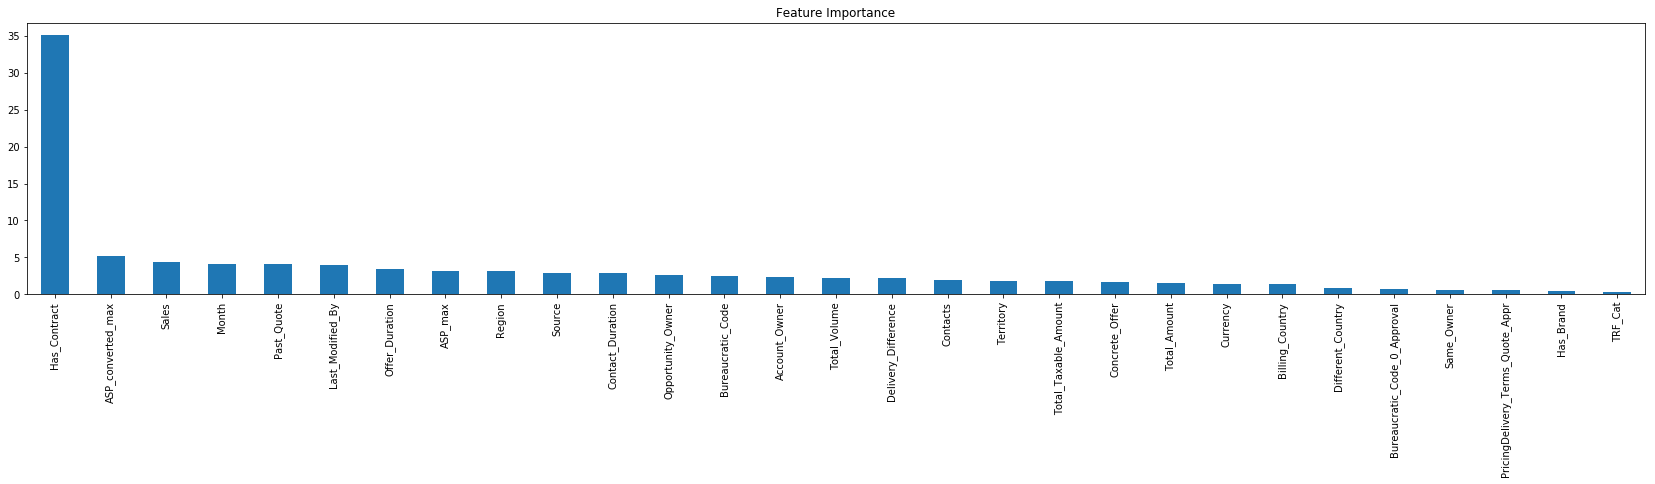

In [32]:
predictors = [x for x in x_train.drop(target, axis = 1).columns]
print len(predictors)
feat_imp = pd.Series(model.feature_importances_, predictors).sort_values(ascending = False)
feat_imp = feat_imp[0:29]
plt.rcParams['figure.figsize'] = 29, 5
feat_imp.plot(kind = 'bar', title = 'Feature Importance')

In [33]:
bad = x_test_pred[(x_test_pred.Prediction > 0.5) & (x_test_pred.Stage == 0) | (x_test_pred.Prediction < 0.5) & (x_test_pred.Stage == 1)]

In [37]:
bad

,Region,Territory,PricingDelivery_Terms_Quote_Appr,PricingDelivery_Terms_Approved,Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Bureaucratic_Code,Source,Billing_Country,Opportunity_ID,Sales_Contract_No,Account_Owner,Opportunity_Owner,Currency,Last_Modified_By,Month,Total_Amount,Total_Taxable_Amount,Stage,Contacts,Delivery_Difference,Same_Owner,Has_Brand,Has_Contract,Different_Country,TRF_Cat,Sales,Concrete_Offer,Offer_Duration,Total_Volume,ASP_max,ASP_converted_max,Territory_Defined,Past_Quote,Contact_Duration,Prediction
7812,APAC,Australia,1,0,1,0,Bureaucratic_Code_5,None,Australia,4832,2252,Person_Name_43,Person_Name_19,None,Person_Name_47,11,109620.00,109620.00,0,1,7.0,False,False,True,False,0.0,196,False,130.0,109620.00,0.5400,0.38211,True,131.0,1589,0.986256
4773,APAC,India,1,1,1,1,Bureaucratic_Code_4,Source_13,Sri Lanka,2824,904,Person_Name_49,Person_Name_49,None,Person_Name_47,12,157172.40,157172.40,0,1,19.0,False,False,True,True,0.0,23,False,72.0,157172.40,0.3600,0.36000,True,-27.0,844,0.996351
9800,APAC,Thailand,0,0,0,0,Bureaucratic_Code_4,Source_7,Thailand,6207,3436,Person_Name_54,Person_Name_54,None,Person_Name_47,12,120060.00,120060.00,0,1,0.0,False,False,True,False,0.0,1,False,57.0,120060.00,0.4000,0.40000,True,70.0,127,0.992064
952,EMEA,Germany,1,0,0,0,Bureaucratic_Code_5,Source_7,Germany,511,1344,Person_Name_4,Person_Name_4,None,Person_Name_41,4,287525.00,287525.00,0,1,12.0,False,False,True,False,1.0,9,False,8.0,287525.00,0.3875,0.43830,True,603.0,651,0.995251
16800,EMEA,None,0,0,0,0,Bureaucratic_Code_4,None,Luxembourg,12726,None,Person_Name_18,Person_Name_20,None,Person_Name_20,1,105300.00,105300.00,1,1,3.0,False,False,False,False,0.0,2,False,72.0,105300.00,0.5400,0.61079,False,-8.0,717,0.083633
9280,Americas,NW America,0,0,0,0,Bureaucratic_Code_4,None,United States,5834,2880,Person_Name_64,Person_Name_64,None,Person_Name_47,12,30702.00,30702.00,0,1,0.0,False,False,True,True,0.0,14,False,4.0,30702.00,0.4300,0.43000,True,183.0,328,0.777722
10407,Americas,None,1,0,0,0,Bureaucratic_Code_5,Source_7,United States,6515,3390,Person_Name_33,Person_Name_33,None,Person_Name_47,1,285862.50,285862.50,0,1,30.0,False,False,True,False,1.0,56,False,NaN,285862.50,0.4950,0.49500,False,NaN,706,0.992866
15533,EMEA,Germany,1,1,1,1,Bureaucratic_Code_4,Source_7,Germany,9934,None,Person_Name_62,Person_Name_62,None,Person_Name_62,10,10666.25,10666.25,1,1,2.0,True,False,False,False,0.0,26,True,NaN,10666.25,0.2300,0.26015,True,NaN,779,0.293523
7806,APAC,Australia,1,1,1,1,Bureaucratic_Code_4,None,Australia,4826,2247,Person_Name_43,Person_Name_19,None,Person_Name_47,11,109620.00,109620.00,0,1,7.0,False,False,True,False,0.0,196,False,130.0,109620.00,0.5400,0.38211,True,131.0,1589,0.978315
16714,EMEA,United Kingdom,1,1,1,1,Bureaucratic_Code_4,Source_11,United Kingdom,12695,None,Person_Name_18,Person_Name_18,None,Person_Name_39,1,1521000.00,3042000.00,1,1,7.0,False,False,False,False,1.0,5,False,26.0,1521000.00,0.5000,0.56555,True,409.0,933,0.490736


In [38]:
validation_file = "Validacion_ECI_2020.csv"
vali = pd.read_csv(validation_file)
validation = preprocess(vali)
leak = ["Opportunity_ID", "Sales_Contract_No"]
pred = model.predict_proba(validation.drop(leak, axis = 1))[:,1]

# agrupo por Opportunity_ID para dar una sola prediccion por solicitud

pred = pd.DataFrame(pred, index = validation.index, columns = ["Prediction"])
validation = validation.join(pred)

answer = pd.DataFrame(validation.groupby("Opportunity_ID", as_index = False)["Prediction"].mean())

In [39]:
prev = pd.read_csv("best/modellgbold_pred.csv", names=["Opportunity_ID", "Prediction"])
prev["Prediction"].corr(answer["Prediction"])

0.9932534105664851

In [40]:
prev = pd.read_csv("best/model_xgb_pred.csv", names=["Opportunity_ID", "Prediction"])
prev["Prediction"].corr(answer["Prediction"])

0.9911569675053407

In [41]:
prev = pd.read_csv("best/modelada_pred.csv", names=["Opportunity_ID", "Prediction"])
prev["Prediction"].corr(answer["Prediction"])

0.9928061879515976

In [42]:
prev = pd.read_csv("best/modelcat_pred.csv", names=["Opportunity_ID", "Prediction"])
prev["Prediction"].corr(answer["Prediction"])

0.9974130143018533

In [43]:
prev = pd.read_csv("best/avg_lgb_xgb_ada_cat.csv", names=["Opportunity_ID", "Prediction"])
prev["Prediction"].corr(answer["Prediction"])

0.996291869870288

In [44]:
answer.to_csv("catb_new_features.csv", header = False, index = False)

In [51]:
lgbm = pd.read_csv("fabri/lgbm.csv", names=["Id", "LGBM"])

In [52]:
xgb = pd.read_csv("fabri/xgb.csv", names=["Id", "XGB"]).drop("Id", axis=1)

In [53]:
catb = pd.read_csv("fabri/catb2.csv", names=["Id", "CATB"]).drop("Id", axis=1)

In [54]:
adab = pd.read_csv("fabri/adab2.csv", names=["Id", "ADAB"]).drop("Id", axis=1)

In [55]:
full = lgbm.join(xgb).join(catb).join(adab).drop('LGBM', axis=1)

In [56]:
full.XGB.corr(full.CATB)

0.9940014543236237

In [57]:
full.XGB.corr(full.ADAB)

0.9970269542862235

In [58]:
full.ADAB.corr(full.CATB)

0.9924745865832904

In [59]:
full.head()

,Id,XGB,CATB,ADAB
0,10689,0.997061,0.998040,0.998755
1,10690,0.992818,0.996455,0.997990
2,10691,0.975783,0.986605,0.985792
3,10692,0.976373,0.989770,0.997229
4,10693,0.972380,0.953184,0.995830


In [60]:
full["Final"] = full.apply(lambda x: calculate([x['CATB'], x['ADAB']], 0.001), axis=1)

In [48]:
def calculate(preds, offset):
    mean = sum(preds) / len(preds)
    return mean
    #return np.clip(mean, 0 + offset, 1 - offset)

In [548]:
full["Final"] = full.apply(lambda x: calculate([x['LGBM'], x['XGB'], x['CATB']]), axis=1)

In [61]:
full[["Id", "Final"]].to_csv("fabri/avg_adab2_catb2.csv", header = False, index = False)

In [563]:
modellgbold = pd.read_csv("best/modellgbold_pred.csv", names=["Id", "LGBOLD"])

In [564]:
modelcat = pd.read_csv("best/modelcat_pred.csv", names=["Id", "CATB"]).drop("Id", axis=1)

In [565]:
modelada = pd.read_csv("best/modelada_pred.csv", names=["Id", "ADA"]).drop("Id", axis=1)

In [566]:
modelxgb = pd.read_csv("best/model_xgb_pred.csv", names=["Id", "XGB"]).drop("Id", axis=1)

In [567]:
fullmodels = modellgbold.join(modelcat).join(modelada).join(modelxgb)

In [602]:
fullmodels.head(10)

,Id,LGBOLD,CATB,ADA,XGB,Final
0,10689,0.997994,0.997574,0.999471,0.996613,0.997913
1,10690,0.991791,0.994675,0.997299,0.979186,0.990738
2,10691,0.992083,0.969127,0.994164,0.908210,0.965896
3,10692,0.926446,0.978247,0.996771,0.980566,0.970507
4,10693,0.979495,0.967347,0.984526,0.968971,0.975085
5,10694,0.979495,0.976924,0.980587,0.928566,0.966393
6,10695,0.011361,0.000530,0.027921,0.066383,0.026549
7,10696,0.007405,0.000426,0.038997,0.063532,0.027590
8,10697,0.024714,0.001642,0.080582,0.142011,0.062237
9,10698,0.004736,0.000530,0.014155,0.009440,0.007215


In [601]:
fullmodels["Final"] = fullmodels.apply(lambda x: calculate([x['LGBOLD'], x['XGB'], x['ADA'], x['CATB']], 0.0005), axis=1)

In [1]:
fullmodels[["Id", "Final"]].to_csv("fabri/testsubimission9.csv", header = False, index = False)

NameError: name 'fullmodels' is not defined

In [ ]:
target_ensamble = ["Stage", "Opportunity_ID"]

ens_parameters = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'is_unbalance': True,
    'boosting': 'gbdt',
    'feature_fraction': 0.3,
    'learning_rate': 0.05    
}

full_data = lgb.Dataset(data = df_ensamble.drop(target_ensamble, axis = 1), label = df_ensamble.Stage)
cv_results = lgb.cv(ens_parameters, full_data, num_boost_round = 1000, nfold = 5, early_stopping_rounds = 100)
cv_results["binary_logloss-mean"][-1]